RAG demo

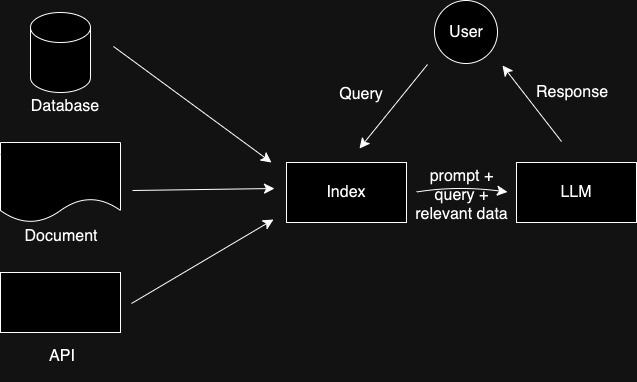

In [ ]:
from IPython.display import Image
display(Image(filename='/content/RAGpipe.jpg'))

In [ ]:
!pip install sentence_transformers
!pip install faiss-cpu
!pip install openai
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import openai
from openai import OpenAI
import numpy as np
openai.api_key = 'sk-proj-'
client = OpenAI(api_key=openai.api_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
file_path = '/content/files/News_Category_Dataset_v3.json'  # Replace with the actual path to your dataset
data = pd.read_json(file_path, lines=True)

# Check the first few rows
print(data.head())
print("\n")

# Get summary info
print(data.info())
print("\n")

# Check for missing values
print(data.isnull().sum())
print("\n")
print("\n")

sampled_df = data.head(1000)
# relevant_data = sampled_df['headline'] + " - " + sampled_df['short_description'] + " - " + sampled_df['date'].astype(str)
relevant_data = sampled_df['short_description']
print(relevant_data.head())
print(relevant_data.info())

                                                                                                                                     link  \
0                                                      https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9   
1  https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe   
2                                     https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02   
3                                                     https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479   
4                    https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e   

                                                                                    headline  \
0               Over 4 Million Americans Roll Up Sleeves 

In [ ]:
# (OPTIONAL, DEPENDING ON DATASET) FILTER RELEVANT DATA

filtered_data = data[data['category'] == 'U.S. NEWS']
recent_filtered_data = filtered_data[filtered_data['date'] >= '2022-01-23']

# Combine headline, short description, and date into a single string for easier retrieval
headDateAndDescription = recent_filtered_data['headline'] + " - " + recent_filtered_data['short_description'] + " - " + recent_filtered_data['date'].astype(str)

pd.set_option('display.max_colwidth', None)
print(headDateAndDescription.head())

0                      Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters - Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall. - 2022-09-23
1    American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video - He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles. - 2022-09-23
4                   Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer - Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral. - 2022-09-22
5                    Cleaner Was Dead In Belk Bathroom For 4 Days Before Body Found: Police - The 63-year-old woman was seen working at the South Carolina store on Thursday. She was found de

In [ ]:
# Step 1: Embed the documents
print("Embedding documents...")
# relevant_data Too big, taking a smaller subset

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
document_embeddings = model.encode(relevant_data.tolist(), convert_to_tensor=True)

# Step 2: Set up FAISS for similarity search
dimension = document_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(document_embeddings))

Embedding documents...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def retrieve_relevant_docs(query, num_results=3):
    query_embedding = model.encode([query])                                           # Embedding query
    distances, indices = faiss_index.search(np.array(query_embedding), num_results)   # Nearest neighbour

    retrieved_documents = [relevant_data.iloc[i] for i in indices[0]]
    return retrieved_documents

In [ ]:
OPENAI_API_KEY = "sk-proj-"
client = OpenAI(api_key=OPENAI_API_KEY)

def gpt4_response(prompt):
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

In [ ]:
# gpt4 test
# resp = gpt4_response("What are the major trends in U.S. news related to project management softwares?")
# print(resp, "/n")

# Testing retrieval
search_data = retrieve_relevant_docs("TV shows and movies")
print(search_data)

['The streaming service announced the movies and shows arriving soon.', 'A new animated film and action comedy are also trending on the streaming service.', 'Films like "Can\'t Hardly Wait," "Clueless" and "Cruel Intentions" held up an unflinching mirror to the roles young people were socialized to play in a heteronormative society.']


In [ ]:
# Step 3: Integrating RAG - Prompt GPT-4 with retrieved documents

def get_insights_from_query(query):
    # Retrieve relevant documents
    relevant_docs = retrieve_relevant_docs(query)

    # Generate insights using GPT-4 based on retrieved documents
    prompt = f"""

    Based on the following news articles: \n\n```{relevant_docs}```\n\n

    Provide competitive insights and suggest actions.

    """

    insights = gpt4_response(prompt)

    return insights

# Test the RAG setup
query = "What are the latest trends in Hollywood ?"
insights = get_insights_from_query(query)
print("Generated Insights: \n", insights)

Generated Insights: 
 Insights:

1. The upcoming film about the music superstar shows that even successful artists may still struggle with recognition and respect. This might lead to increased interest in music biopics or true stories.
2. The fact that the model attended the 2022 Grammy Awards with her husband, Justin Bieber, and media's immediate speculation indicates the public's interest in celebrity lifestyle and relationships.
3. The new docuseries about the iconic pop group reviews how the music industry has fostered a fascination with young male talent. This might suggest a renewed interest in behind-the-scenes industry insights and the journey of musicians.

Actions:

1. To capitalize on the interest in music biopics, production studios could consider developing more movies or series based on the lives of popular musicians or bands. This gives fans insight into their favorite artists' challenges and triumphs. Companies can also run campaigns to bring more attention to these pro

# Evaluation


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Prompt Evaluation

expected_output = ""
predicted_output = gpt4_response(prompt)  # retrieved docs

# Calculate metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')





ground_truth = ['The streaming service announced the movies and shows arriving soon.', 'A new animated film and action comedy are also trending on the streaming service.', 'Films like "Can\'t Hardly Wait," "Clueless" and "Cruel Intentions" held up an unflinching mirror to the roles young people were socialized to play in a heteronormative society.']             # correct most relevant docs

# Manually setting most important docs
ground_truth_relevant_docs = [
    "Expected document 1",
    "Expected document 2",
    "Expected document 3"
]

def evaluate_retrieval(query, num_results=3):
    # Retrieve documents using the RAG system
    retrieved_docs = retrieve_relevant_docs(query, num_results)

    # Create a binary list: 1 if retrieved document is in ground truth, 0 otherwise
    y_true = [1 if doc in ground_truth_relevant_docs else 0 for doc in retrieved_docs]
    y_pred = [1] * len(retrieved_docs)  # Assume all retrieved are predicted as relevant

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    return precision, recall, f1

# Test the evaluation with a query
query = "What are the latest trends in Hollywood?"
precision, recall, f1 = evaluate_retrieval(query)

NameError: name 'search_data' is not defined

In [ ]:
# import pandas as pd
# import json
# import os
# !pip install pdfplumber
# !pip install PyPDF2
# import PyPDF2
# import pdfplumber

# Function to load data from different file types
def load_data(file_path):
    file_type = file_path.split('.')[-1].lower()

    if file_type == 'pdf':
        return load_pdf(file_path)
    elif file_type == 'csv':
        return pd.read_csv(file_path)
    elif file_type == 'json':
        return load_json(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")

# Function to load PDFs
def load_pdf(file_path):
    text = ""
    try:
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        print(f"Error reading PDF file {file_path}: {e}")
        return None
    return text

# Function to load JSON data
def load_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        # Convert JSON to DataFrame only if it's structured
        if isinstance(data, list) or isinstance(data, dict):
            return pd.DataFrame(data) if isinstance(data, list) else pd.json_normalize(data)
        else:
            raise ValueError(f"Unexpected JSON format in file {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error processing JSON file {file_path}: {e}")
        return None

# Load and preprocess data from a folder containing multiple files
def process_data_folder(folder_path):
    combined_data = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            data = load_data(file_path)
            if data is not None:
                combined_data.append(data)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    return combined_data

# Example: Processing a folder with PDFs, CSVs, and JSONs
folder_path = '/content/data_1'
combined_data = process_data_folder(folder_path)

# Check the processed data
print(combined_data)


Error processing .ipynb_checkpoints: Unsupported file type: ipynb_checkpoints
[     sepalLength  sepalWidth  petalLength  petalWidth    species
0            5.1         3.5          1.4         0.2     setosa
1            4.9         3.0          1.4         0.2     setosa
2            4.7         3.2          1.3         0.2     setosa
3            4.6         3.1          1.5         0.2     setosa
4            5.0         3.6          1.4         0.2     setosa
..           ...         ...          ...         ...        ...
145          6.7         3.0          5.2         2.3  virginica
146          6.3         2.5          5.0         1.9  virginica
147          6.5         3.0          5.2         2.0  virginica
148          6.2         3.4          5.4         2.3  virginica
149          5.9         3.0          5.1         1.8  virginica

[150 rows x 5 columns],             Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AU

In [ ]:
import pandas as pd
import json
import os
import PyPDF2
import pdfplumber

# Function to load data from different file types
def load_data(file_path):
    file_type = file_path.split('.')[-1].lower()

    if file_type == 'pdf':
        return load_pdf(file_path)
    elif file_type == 'csv':
        return pd.read_csv(file_path)
    elif file_type == 'json':
        return load_json(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")

# Function to load PDFs
def load_pdf(file_path):
    text = ""
    try:
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        print(f"Error reading PDF file {file_path}: {e}")
        return None
    return text

# Function to load JSON data
def load_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        if isinstance(data, list) or isinstance(data, dict):
            return pd.DataFrame(data) if isinstance(data, list) else pd.json_normalize(data)
        else:
            raise ValueError(f"Unexpected JSON format in file {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error processing JSON file {file_path}: {e}")
        return None

# Load and preprocess data from a folder containing multiple files
def process_data_folder(folder_path):
    combined_data = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.startswith("."):  # Skip hidden/system files like `.ipynb_checkpoints`
            continue
        try:
            data = load_data(file_path)
            if data is not None:
                if isinstance(data, pd.DataFrame):
                    # Convert DataFrame rows to a string
                    data_str = data.apply(lambda row: ' '.join(row.astype(str)), axis=1).str.cat(sep=' ')
                    combined_data.append(data_str)
                elif isinstance(data, str):
                    combined_data.append(data)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    return combined_data

# Example: Processing a folder with PDFs, CSVs, and JSONs
folder_path = '/content/data_1'
combined_data = process_data_folder(folder_path)

# After processing, join all data into a single text block
all_text_data = " ".join([str(item) for item in combined_data])  # Ensure all items are converted to strings

print(all_text_data)

Buffered data was truncated after reaching the output size limit.

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Now, use the existing embedding and retrieval system
document_embeddings = model.encode([all_text_data], convert_to_tensor=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]